In [1]:
# Entities
import numpy as np

from processing.robotics.arm_propagator import ArmPropagator, ElectromagnetEndEffector, RevoluteJoint
from processing.system_animation import animate_system
from processing.utilities.entities import Cylinder

# Attitude
from processing.attitude.attitude_propagator import AttitudePropagator
from processing.attitude.torques.base import TorqueObject
from processing.attitude.torques.eddy_current import EddyCurrentTorque

# Environment
from propagator.bin.environment import Environment

In [2]:
# Generate debris
debris = Cylinder(
    mass=950.0,
    radius=2.5,
    height=5.0,
    thickness=0.1,
    sigma=35000000.0
)

# Generate robotic arms (UR10 standard)
# Joints
joints = [
    RevoluteJoint(0, 0.5, np.pi/2),
    RevoluteJoint(2.5, 0, 0),
    RevoluteJoint(2.5, 0, 0),
    RevoluteJoint(0, 0.5, np.pi/2),
    RevoluteJoint(0, 0.25, -np.pi/2),
    RevoluteJoint(0, 0.25, 0)
]

# CoM
com = [
    [0, -joints[0].d/2, 0],
    [joints[1].a/2, 0, 0],
    [joints[2].a/2, 0, 0],
    [0, -joints[3].d/2, 0],
    [0, joints[4].d/2, 0],
    [0, 0, -joints[5].d/2]
]

# End effector
electromagnet: ElectromagnetEndEffector = ElectromagnetEndEffector(
    n_turns=500.0,
    radius=1.0,
    current=50.0
)

# External moments
# Eddy current
eddy: TorqueObject = EddyCurrentTorque(
    entity=debris,
    chaser_w0=[0.0, 0.0, 0.0],
    electromagnets=[electromagnet]
)

# Save attitude results
attitude = AttitudePropagator(entity=debris, M_ext=eddy)

# Save robotic arm results
base_offset = np.array([10, 0, 5])
max_torques = np.array([.05, .05, .05, .05, .05, .05])
arm = ArmPropagator(joints=joints, com=com, end_effector=electromagnet, base_offset=base_offset, max_torques=max_torques)

In [3]:
# Set propagation settings
t_step = .1  # Propagation time step [s]

# Set initial conditions
y0_arm = [
    0, 0.7, 0.3, 0.0, 0.0, 0.0,   # Initial joint angles
    0.02, 0.0, 0.0, 0.0, 0.0, 0.0   # Initial joint velocities
]

y0_debris = [
    0.1, 0.2, 0.0,                    # Initial debris angular velocity
    0.0, 0.0, 0.0, 1.0                # Initial debris quaternions
]

# Initialize environment
env = Environment(
    y0_arm + y0_debris,                   # Initial conditions
    debris.Ixx,                           # Debris Ixx
    debris.Iyy,                           # Debris Iyy
    debris.Izz,                           # Debris Izz
    debris.radius,                        # Debris cylinder radius
    debris.height,                        # Debris cylinder height 
    debris.thickness,                     # Debris cylinder thickness
    debris.sigma,                         # Debris conductivity
    electromagnet.n_turns,                # Coil number of turns
    electromagnet.current,                # Coil current
    electromagnet.radius,                 # Coil radius
    arm.base_offset_x,                    # Arm base x-offset
    arm.base_offset_y,                    # Arm base y-offset
    arm.base_offset_z,                    # Arm base z-offset
    arm.dh_a,                             # Arm joint a parameters
    arm.dh_d,                             # Arm joint d parameters
    arm.dh_alpha,                         # Arm joint alpha parameters
    arm.max_torques,                      # Arm joint max torques
    arm.com                               # Arm link CoMs
    )

## Save initial conditions

In [4]:
def save(tf, prop):
    # to numpy
    prop = np.array(prop)
    
    # save
    arm.save_new(tf, prop=prop)
    attitude.save_new(tf, prop=prop)
    
# Get initial state
t, s = env.current_state()
save(t, s)

### Inverse kinematics

In [5]:
# Solve inverse kinematics
TD = np.array([
         [1.0000,      0,         0,   -4.0000],
         [0     ,      0,   -1.0000,    1.7500],
         [0     , 1.0000,         0,    0.2500],
         [0     ,      0,         0,    1.0000]
    ])
yD_arm = arm.inverse_kinematics(TD, np.array(y0_arm[:6]), 1e-13, 100)
T_c = arm.get_transformation(yD_arm, 6)

Converged:  [0.00000000e+00 2.22044605e-16 1.63757896e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [6]:
print("Final angles [deg]: ", np.rad2deg(yD_arm))
print("Final angles [rad]: ", yD_arm)
print("Final EE position: ", T_c[:3, -1] + arm.base_offset)

Final angles [deg]:  [160.98496709 327.84900227  65.31747127  32.01608067 126.514607
  50.52726719]
Final angles [rad]:  [2.80971772 5.72204454 1.14000493 0.55878602 2.20809644 0.88186717]
Final EE position:  [6.   1.75 5.25]


## Loop

In [7]:
# Set control parameters
env.set_control_torque(yD=list(yD_arm))

# Perform steps
while t < 50:
    # Perform step
    t, s = env.step(t_step=t_step)
    save(t, s)

TD = np.array([
         [1.0000,      0,         0,   -3.0000],
         [0     ,      0,   -1.0000,    1.7500],
         [0     , 1.0000,         0,    0.2500],
         [0     ,      0,         0,    1.0000]
    ])
yD_arm = arm.inverse_kinematics(TD, yD_arm, 1e-13, 100)

# Set control parameters
env.set_control_torque(yD=list(yD_arm))

 # Perform steps
while t < 100:
    # Perform step
    t, s = env.step(t_step=t_step)
    save(t, s)   
    
TD = np.array([
         [1.0000,      0,         0,   -4.0000],
         [0     ,      0,   -1.0000,    1.7500],
         [0     , 1.0000,         0,    1.2500],
         [0     ,      0,         0,    1.0000]
    ])
yD_arm = arm.inverse_kinematics(TD, yD_arm, 1e-13, 100)

# Set control parameters
env.set_control_torque(yD=list(yD_arm))

 # Perform steps
while t < 150:
    # Perform step
    t, s = env.step(t_step=t_step)
    save(t, s)   

At (0) t = 1.0000e-01    y =  2.138363e-03    7.002499e-01    3.000418e-01    2.780361e-05    1.098686e-04    4.387921e-05    2.276628e-02
At (1) t = 2.0000e-01    y =  4.553060e-03    7.009991e-01    3.001671e-01    1.111623e-04    4.392684e-04    1.754345e-04    2.552668e-02
At (2) t = 3.0000e-01    y =  7.243503e-03    7.022468e-01    3.003758e-01    2.499979e-04    9.878904e-04    3.945426e-04    2.828120e-02
At (3) t = 4.0000e-01    y =  1.020911e-02    7.039925e-01    3.006678e-01    4.442321e-04    1.755426e-03    7.010801e-04    3.102984e-02
At (4) t = 5.0000e-01    y =  1.344928e-02    7.062354e-01    3.010429e-01    6.937870e-04    2.741566e-03    1.094924e-03    3.377262e-02
At (5) t = 6.0000e-01    y =  1.696343e-02    7.089747e-01    3.015011e-01    9.985841e-04    3.946001e-03    1.575950e-03    3.650952e-02
At (6) t = 7.0000e-01    y =  2.075098e-02    7.122098e-01    3.020423e-01    1.358545e-03    5.368422e-03    2.144035e-03    3.924055e-02
At (7) t = 8.0000e-01    y 

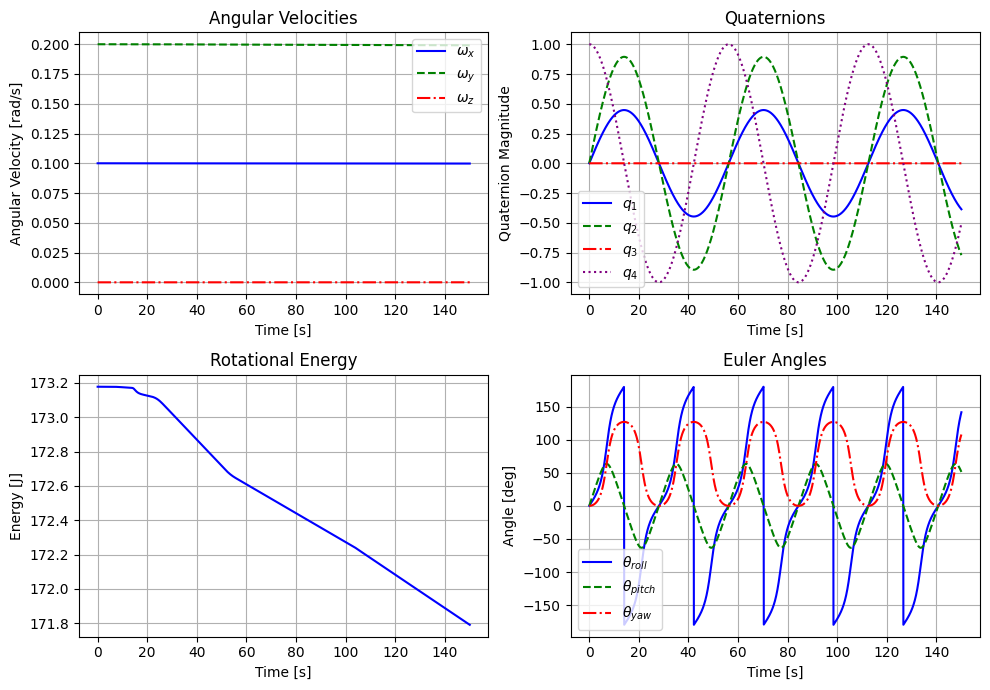

In [8]:
attitude.plot(["angular_velocity", "quaternions", "energy", "euler_angles"])

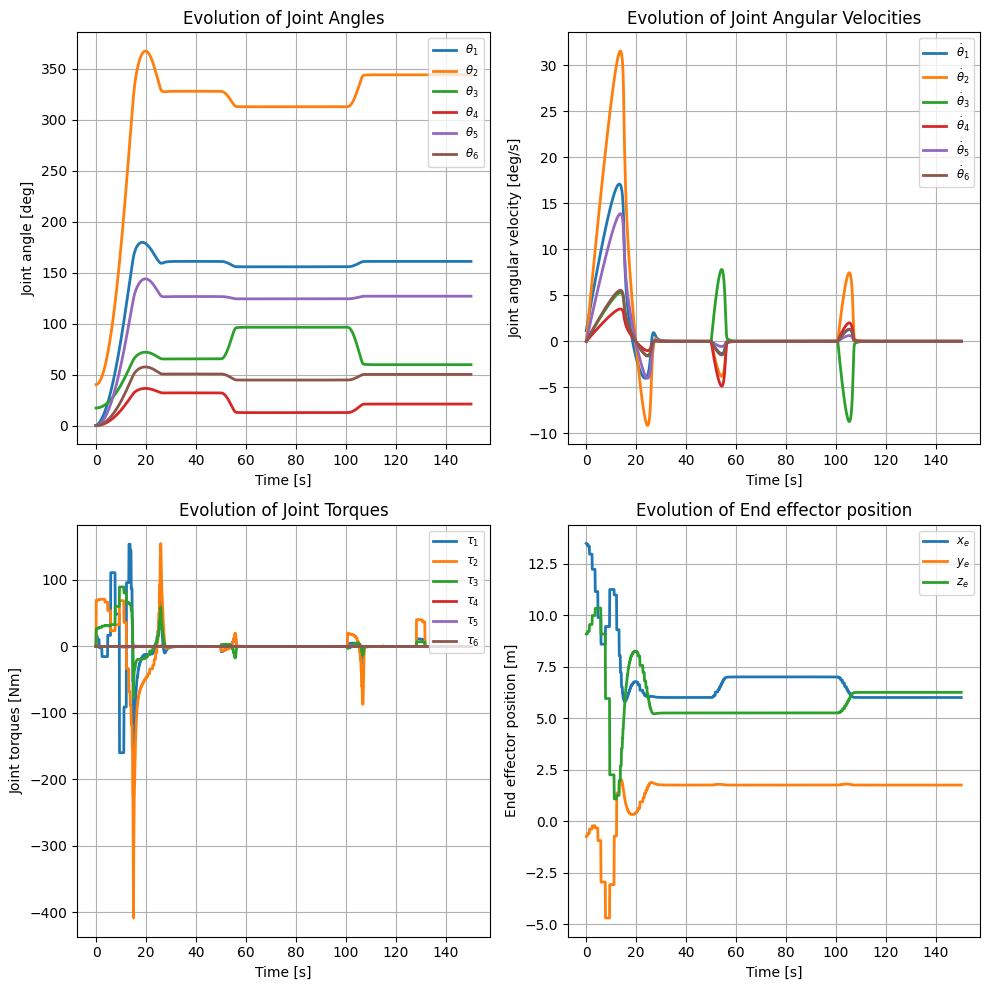

In [9]:
arm.plot()

- Animation rendering progress -
[=====================]  100.00% (1502/1502) ETA: 0m 0s


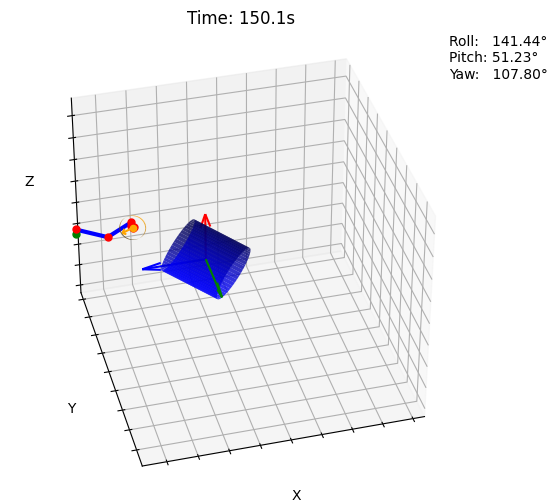

In [10]:
animate_system(
    t=attitude.t,
    q=attitude.q,
    eu=attitude.euler_angles,
    h=debris.height,
    r=debris.radius,
    dpi=300,
    arms=[arm],
    dh_par=joints
)